In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from geopy.geocoders import Nominatim
import pickle
import matplotlib.pyplot as plt

## Prepare data

In [2]:
timeline_data = pd.read_csv('./data/parsed/timeline_data.csv')
timeline_data.shape

(886010, 5)

In [3]:
timeline_data.head()

,id,timestampMs,latitudeE7,longitudeE7,accuracy
0,1,1395342553730,546874623,254226240,1019
1,2,1395342618598,546874623,254226240,1019
2,3,1395342818959,546880661,254107441,1440
3,4,1395342880250,546795194,254136012,1605
4,5,1395342999179,546795194,254136012,1605


In [4]:
# Converting unix timestamp to local date
timeline_data['datetime_original'] = pd.to_datetime(timeline_data['timestampMs'] / 1000, unit='s')
timeline_data['datetime_local'] = timeline_data['datetime_original'].dt.tz_localize('utc').dt.tz_convert('Europe/Vilnius')
timeline_data['date'] = timeline_data['datetime_local'].dt.date

In [5]:
# Converting latitude and longitude to correct format
timeline_data['latitude'] = timeline_data['latitudeE7'] / 1e7
timeline_data['longitude'] = timeline_data['longitudeE7'] / 1e7

In [6]:
# Leaving only data points with high accuracy (< 1000)
timeline_data = timeline_data[timeline_data['accuracy'] < 1000]

In [7]:
# Removing unnecessary columns
timeline_data = timeline_data[['date','latitude','longitude']]
timeline_data.shape

(752514, 3)

In [8]:
timeline_data.head()

,date,latitude,longitude
11,2014-03-20,54.667884,25.312876
14,2014-03-20,54.679505,25.287449
15,2014-03-20,54.679969,25.282376
16,2014-03-20,54.682736,25.279832
17,2014-03-20,54.683094,25.276664


In [9]:
# Grouping by date and finding median latitude and longitude values for each day
timeline_data_grouped = timeline_data.groupby('date').median().reset_index()
timeline_data_grouped.shape

(1918, 3)

In [10]:
timeline_data_grouped.head()

,date,latitude,longitude
0,2014-03-20,54.672454,25.250688
1,2014-03-21,54.695233,25.291235
2,2014-03-22,54.703384,25.296075
3,2014-03-23,54.672463,25.250683
4,2014-03-24,54.672464,25.250671


=======================================================

The reason for grouping all the data points by date is to minimize the number of coordinates for country extraction and have only 1 coordinate per day, which is a median of coordinates. It should reveal the most probable location for each day.

The logic for extracting median of coordinates when grouping by day is to find the middle coordinates of all the coordinates during the day. This is better measure than first or last coordinates of the day, which might not capture all the abroad presence if the trip is starting/ending at the home country.

=======================================================

## Extract country from coordinates

In [12]:
# Extract location from latitude and longitude using geopy
geolocator = Nominatim(user_agent='my_google_timeline_project')

coordinates = list(timeline_data_grouped[['latitude','longitude']].itertuples(index=False, name=None))

locations = dict()
i = 0

for coord in coordinates:
    location = geolocator.reverse(coord)
    locations[i] = location
    i += 1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918


In [13]:
len(locations)

1918

In [14]:
# Save extracted locations to pickle file
with open('locations.pickle', 'wb') as handle:
    pickle.dump(locations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# Load extracted locations (once locations are extracted above, no need to rerun the above code)
with open('locations.pickle', 'rb') as handle:
    locations = pickle.load(handle)

In [16]:
# The example of location string extracted using geopy
locations[0][0]

'5, Žemaitės g., Naujamiesčio namai, Vilkpėdės seniūnija, Vilnius, Vilniaus miesto savivaldybė, Vilniaus apskritis, 03125, Lietuva'

In [17]:
# Extract country from locations
countries = dict()

for i, loc in locations.items():
    location_parsed = loc[0].split(',')
        
    if len(location_parsed) > 0:
        country = location_parsed[-1].strip()
    else:
        country = ''
        
    countries[i] = [country]

In [18]:
# Join extracted country to dates
locations_df = pd.DataFrame(countries).T
locations_df.rename(columns={0:'country'}, inplace=True)
timeline_data_joined = timeline_data_grouped.join(locations_df)
timeline_data_joined.shape

(1918, 4)

In [19]:
timeline_data_joined.head()

,date,latitude,longitude,country
0,2014-03-20,54.672454,25.250688,Lietuva
1,2014-03-21,54.695233,25.291235,Lietuva
2,2014-03-22,54.703384,25.296075,Lietuva
3,2014-03-23,54.672463,25.250683,Lietuva
4,2014-03-24,54.672464,25.250671,Lietuva


## Analyze countries visited

In [20]:
# Number of days in each country during the whole period
timeline_data_joined['country'].value_counts()

Lietuva           1815
Danmark             39
España              14
United States       11
Italia              10
Portugal             6
Ελλάς                6
Eesti                5
United Kingdom       4
Deutschland          4
San Marino           1
Latvija              1
Česko                1
Polska               1
Name: country, dtype: int64

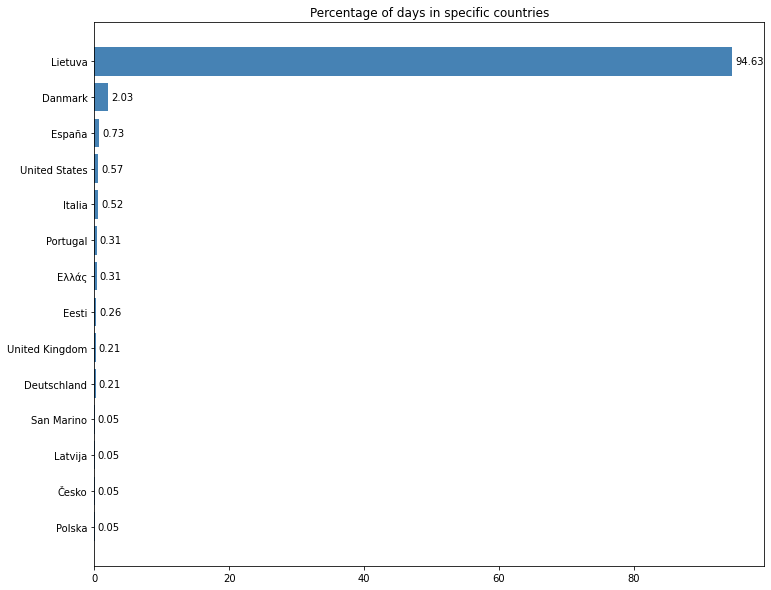

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))

countries = np.array(timeline_data_joined['country'].value_counts().index)[::-1]
countries_each = timeline_data_joined['country'].value_counts()
countries_tot = timeline_data_joined['country'].value_counts().sum()
countries_freq = np.array(round(countries_each / countries_tot * 100, 2))[::-1]

rect = ax.barh(countries, countries_freq, color='steelblue')
ax.bar_label(rect, padding=3)

plt.title('Percentage of days in specific countries')
plt.show()

In [22]:
country_selected = 'Danmark'
timeline_data_joined['date'][timeline_data_joined['country'] == country_selected]

935     2017-02-20
936     2017-02-21
1042    2017-06-07
1043    2017-06-08
1342    2018-04-04
1343    2018-04-05
1344    2018-04-06
1348    2018-04-10
1524    2018-10-03
1525    2018-10-04
1526    2018-10-05
1530    2018-10-09
1531    2018-10-10
1532    2018-10-11
1543    2018-10-22
1544    2018-10-23
1545    2018-10-24
1546    2018-10-25
1547    2018-10-26
1558    2018-11-06
1559    2018-11-07
1560    2018-11-08
1566    2018-11-14
1567    2018-11-15
1569    2018-11-17
1570    2018-11-18
1571    2018-11-19
1572    2018-11-20
1573    2018-11-21
1574    2018-11-22
1580    2018-11-28
1581    2018-11-29
1585    2018-12-03
1586    2018-12-04
1587    2018-12-05
1588    2018-12-06
1639    2019-01-26
1640    2019-01-27
1641    2019-01-28
Name: date, dtype: object

=======================================================

As seen in the graph above, I have spent majority of days in my home country Lithuania (Lietuva) - more than 94% during the period from 2014-03 to 2019-10. Other days were spent in the following countries: Denmark, Spain, US, Italy, Portugal, etc.

The most popular abroad country is Denmark with 39 days spent during the whole period, with the majority of days spent were from 2018 10 to 2018 11. The second popular abroad country is Spain with 14 days spent, all of them in 2016 May, the trip to Fuerteventura in Canaries, Spain.

=======================================================

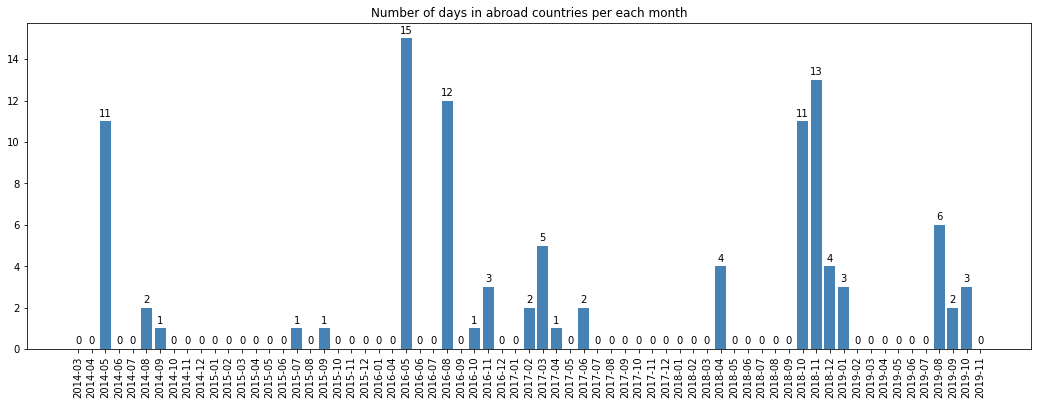

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(18,6))

timeline_data_joined['year_month'] = timeline_data_joined['date'].astype(str).str[:7]
timeline_data_joined_year_month = timeline_data_joined.groupby(['year_month']).count().reset_index()
timeline_data_joined_year_month = timeline_data_joined_year_month[['year_month','date']]
timeline_data_joined_year_month.rename(columns={'date':'monthly_day_count'}, inplace=True)

timeline_data_abroad = timeline_data_joined[timeline_data_joined['country'] != 'Lietuva']
timeline_data_abroad_year_month = timeline_data_abroad.groupby(['year_month']).count().reset_index()
timeline_data_abroad_year_month = timeline_data_abroad_year_month[['year_month','date']]
timeline_data_abroad_year_month.rename(columns={'date':'abroad_day_count'}, inplace=True)

final_data = pd.merge(timeline_data_joined_year_month, timeline_data_abroad_year_month, on='year_month', how='left')
final_data['abroad_day_count'] = final_data['abroad_day_count'].fillna(0)

x = final_data['year_month']
y = final_data['abroad_day_count']

rect = ax.bar(x, y, color='steelblue')
ax.bar_label(rect, padding=3)
plt.xticks(x, rotation='vertical')

plt.title('Number of days in abroad countries per each month')
plt.show()

In [24]:
date_selected = '2017-03'
timeline_data_abroad[timeline_data_abroad['year_month'] == date_selected]

,date,latitude,longitude,country,year_month
970,2017-03-27,41.145402,-8.603914,Portugal,2017-03
971,2017-03-28,38.714914,-9.155085,Portugal,2017-03
972,2017-03-29,37.087399,-8.246294,Portugal,2017-03
973,2017-03-30,37.087399,-8.246223,Portugal,2017-03
974,2017-03-31,41.145463,-8.605202,Portugal,2017-03


=======================================================

It is interesting how many days per month were spent abroad on each month. As we see in the graph above, a lot of months were spent entirely in my home country, but some of the months were spent abroad. The most days per month spent abroad was on 2016 05, the same trip to Fuerteventura, Spain. 

=======================================================